In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)


In [618]:


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy
import seaborn as sns
from neuromancer.loggers import BasicLogger
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)


In [619]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1



In [620]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainU = train_sim['U'][:length].reshape(nbatch, nsteps, nu)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'r': trainX, 'xn': trainX[:, 0:1, :], 'u': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devU = dev_sim['U'][:length].reshape(nbatch, nsteps, nu)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'r': devX, 'xn': devX[:, 0:1, :], 'u': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nbatch*nsteps, nx)
    testU = test_sim['U'][:length].reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'r': testX, 'xn': testX[:, 0:1, :], 'u': testU}

    return train_loader, dev_loader, test_data


In [621]:
nsim = 1000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 50     # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)

In [622]:
theta_1 = library.PolynomialLibrary(nx, nu, 2)

theta_2_funs = [lambda X, u: torch.sqrt(X[:,0]), lambda X, u: torch.sqrt(X[:,1])]
theta_2_names = ["sqrt(x_0)", "sqrt(x_1)"]
theta_2 = library.FunctionLibrary(theta_2_funs, nx, nu, theta_2_names)


fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))

In [623]:
integrator = integrators.Euler(fx, h=ts)
integrator_node = Node(integrator, ['xn', 'u'], ['x'])
x_bound = Node(lambda x: torch.clamp(x, xmin, xmax), ['x'], ['xn'])
dynamics_model = System([integrator_node, x_bound], nsteps=nsteps, name="dynamics_model")

In [624]:
# %% Constraints + losses:
x = variable("r")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

#sparsity
l1 = variable([x], lambda x: torch.norm(list(fx.parameters())[0]))
# loss_l1 = 0.00001*(l1 == 0)        #best so far
loss_l1 = 0.00001*(l1 == 0)


In [625]:


# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss, loss_l1]

# create constrained optimization loss
loss = PenaltyLoss(objectives, [])
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)



In [626]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=500,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=400,
    patience=200,
    logger=logger
)

None
Number of parameters: 34


In [318]:
for _ in range(6):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps *= 2
    dynamics_model.nsteps = nsteps
    trainer.badcount = 0


************   training with 2 steps   ************   
epoch: 0	train_loss: 0.61402	dev_loss: 0.73296	eltime:  0.96173
epoch: 1	train_loss: 0.55506	dev_loss: 0.57949	eltime:  1.01964
epoch: 2	train_loss: 0.45290	dev_loss: 0.46112	eltime:  1.06924
epoch: 3	train_loss: 0.10856	dev_loss: 0.08607	eltime:  1.11848
epoch: 4	train_loss: 0.01851	dev_loss: 0.03529	eltime:  1.17301
epoch: 5	train_loss: 0.03376	dev_loss: 0.03211	eltime:  1.22861
epoch: 6	train_loss: 0.01005	dev_loss: 0.01241	eltime:  1.27845
epoch: 7	train_loss: 0.00540	dev_loss: 0.01318	eltime:  1.32769
epoch: 8	train_loss: 0.00548	dev_loss: 0.00965	eltime:  1.37697
epoch: 9	train_loss: 0.00406	dev_loss: 0.00867	eltime:  1.43175
epoch: 10	train_loss: 0.00513	dev_loss: 0.00878	eltime:  1.48047
epoch: 11	train_loss: 0.00280	dev_loss: 0.00768	eltime:  1.52896
epoch: 12	train_loss: 0.00340	dev_loss: 0.00865	eltime:  1.57870
epoch: 13	train_loss: 0.00349	dev_loss: 0.00675	eltime:  1.63389
epoch: 14	train_loss: 0.00306	dev_loss: 0.006

In [638]:
fx.load_state_dict(torch.load("saved_models/pt_SINDy_Model_20250313_143851.pth"))

<All keys matched successfully>

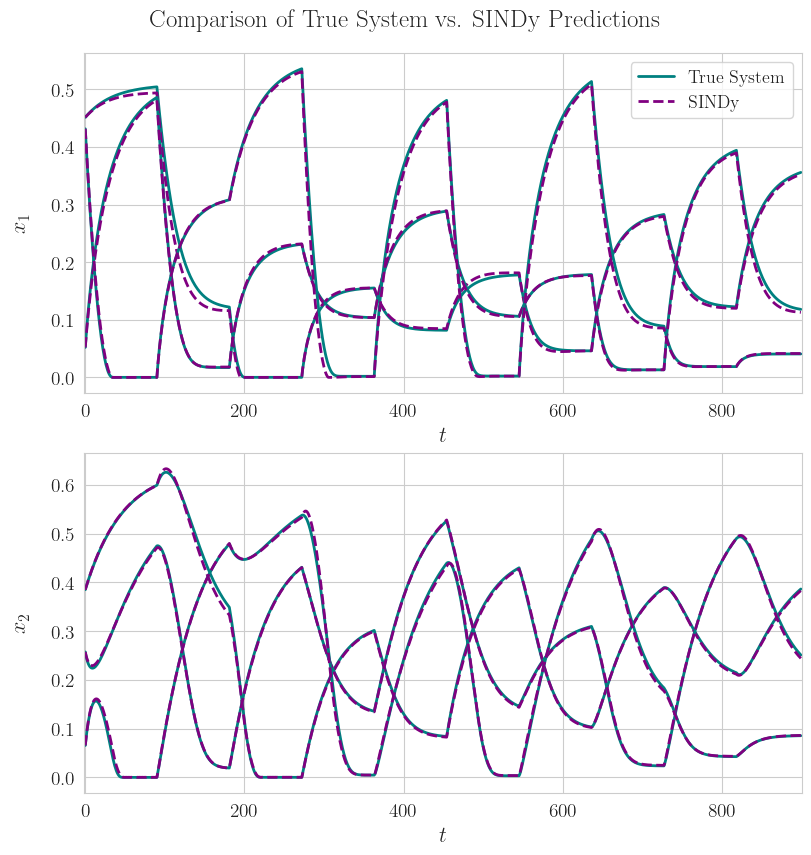

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [383]:
# Set a consistent Seaborn style
sns.set_style('whitegrid')

# Create figure and axes with better spacing
fig, axes = plt.subplots(2, 1, figsize=(8, 8), constrained_layout=True)

nsteps = 300

for _ in range(3):
    train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)
    dynamics_model.nsteps = test_data['r'].shape[1]
    test_output = dynamics_model(test_data)

    pred_traj = test_output['xn'][:, :-1, :]
    true_traj = test_data['r']
    pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
    true_traj = true_traj.detach().numpy().reshape(-1, nx)
    pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)
    nsteps = len(pred_traj[1, :])

    # Generate sample data (Replace these with your actual data)
    time = np.arange(nsteps)

    # Adjust font size globally
    plt.rcParams.update({"font.size": 14, "axes.labelsize": 16, "xtick.labelsize": 14, "ytick.labelsize": 14})
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})
    # --- Plot x vs Time ---
    axes[0].plot(time, true_traj[0, :], color='teal', label='True System', linewidth=2)
    axes[0].plot(time, pred_traj[0, :], color='purple', linestyle='dashed', linewidth=2, label='SINDy', markersize=4)

    axes[0].set_xlabel(r"$t$", fontsize=16)
    axes[0].set_ylabel(r"$x_1$", fontsize=16, labelpad=15)
    axes[0].set_xlim([-1, nsteps])
    if _<=0:
        axes[0].legend(loc='best', fontsize=13, frameon=True)

    # --- Plot u vs Time ---
    axes[1].plot(time, true_traj[1, :], color='teal', linewidth=2)
    axes[1].plot(time, pred_traj[1, :], color='purple', linestyle='dashed', linewidth=2, markersize=4)

    axes[1].set_xlabel(r"$t$", fontsize=16)
    axes[1].set_ylabel(r"$x_2$", fontsize=16, labelpad=15)
    axes[1].set_xlim([-1, nsteps])

fig.suptitle("Comparison of True System vs. SINDy Predictions", fontsize=18, fontweight='bold', y=1.05)

plt.show()
fig.savefig(fname="results/TwoTank/TwoTank_SINDy_Plot.eps", format="eps", bbox_inches="tight")


In [369]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_SINDy_Model" + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(fx.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_SINDy_Model_20250313_143851.pth


In [635]:
def threshold_filter(param, threshold):
    with torch.no_grad():  # Ensure no gradient tracking
        param.data = torch.where(torch.abs(param.data) < threshold, torch.tensor(0.0, device=param.device, dtype=param.dtype), param.data)

threshold = 0.0009
threshold_filter(fx.coef, threshold)


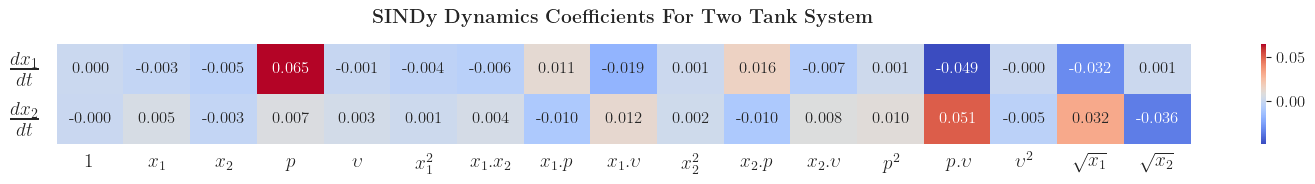

In [639]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = fx.coef.data.numpy()

control_terms_latex = [r"$\frac{dx_1}{dt}$", r"$\frac{dx_2}{dt}$"]
function_names_latex = ['$1$',
 r'$x_1$',
 r'$x_2$',
 r'${p}$',
 r'${\upsilon}$',
 r'$x_1^2$',
 r'$x_1.x_2$',
 r'$x_1.p$',
 r'$x_1.{\upsilon}$',
 r'$x_2^2$',
 r'$x_2.p$',
 r'$x_2.{\upsilon}$',
 r'$p^2$',
 r'$p.\upsilon$',
 r'$\upsilon^2$',
 r'$\sqrt{x_1}$',
 r'$\sqrt{x_2}$']

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(coefficients.T, annot=True, xticklabels=function_names_latex, yticklabels=control_terms_latex, cmap="coolwarm", fmt=".3f", ax=ax)

ax.set_title(r"\textbf{SINDy Dynamics Coefficients For Two Tank System}", fontsize=14, pad=15)
plt.yticks(rotation=0, ha='center', fontsize=20)
ax.tick_params(axis='y', which='major', pad=20)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('bottom')
ax.tick_params(axis='x', bottom=False, top=False, labelbottom=True, labeltop=False)
plt.xticks(rotation=0, ha='center', fontsize=14)

# Make the colorbar labels bigger
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar font size

plt.tight_layout()
plt.savefig(fname="results/TwoTank/TwoTank_SINDy_Coefficients.eps", format="eps", bbox_inches="tight")
plt.show()

### Sparse Dictionary Policy

In [640]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model



In [641]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader



In [653]:
nsteps = 10  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

dx0/dt = 0.496*x_0 + 0.088*x_1 + 0.307*sin(x_0) + 0.490*sin(x_1) + 0.456*x_0^2 + 0.349*x_1^2 + 0.022*x_0 * x_1 + 0.294*r_0 + 0.698*r_1 + 0.161*sqrt(r_0) + 0.682*sqrt(r_1) + 0.397*r_0^2 + 0.419*r_1^2 + 0.953*x_0 * r_0 + 0.185*x_0 * r_1 + 0.305*x_1 * r_0 + 0.176*x_1 * r_1 
dx1/dt = 0.768*x_0 + 0.132*x_1 + 0.634*sin(x_0) + 0.896*sin(x_1) + 0.632*x_0^2 + 0.402*x_1^2 + 0.169*x_0 * x_1 + 0.519*r_0 + 0.800*r_1 + 0.282*sqrt(r_0) + 0.915*sqrt(r_1) + 0.874*r_0^2 + 0.553*r_1^2 + 0.036*x_0 * r_0 + 0.373*x_0 * r_1 + 0.932*x_1 * r_0 + 0.270*x_1 * r_1 



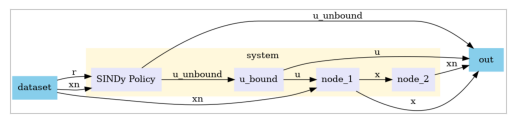

In [654]:
from library import FunctionLibrary
import itertools
torch.manual_seed(0)
# Number of features and control variables
n_features = nx
n_controls = nu

# Create an empty list for features and names
theta_funs = []
theta_names = []

# Degree 1 features (x_i)
theta_funs += [(lambda X, u, i=i: X[:, i]) for i in range(n_features)]
theta_names += [f"x_{i}" for i in range(n_features)]

# Sinusoidal features (sin(x_i))
theta_funs += [(lambda X, u, i=i: torch.sin(X[:, i])) for i in range(n_features)]
theta_names += [f"sin(x_{i})" for i in range(n_features)]

# Squared features (x_i^2)
theta_funs += [(lambda X, u, i=i: x[:, i] ** 2) for i in range(n_features)]
theta_names += [f"x_{i}^2" for i in range(n_features)]

# # Product of x_i and sin(x_i)
# theta_funs += [(lambda X, u, i=i: X[:, i] * torch.sin(X[:, i])) for i in range(n_features)]
# theta_names += [f"x_{i} * sin(x_{i})" for i in range(n_features)]

#Quadratic interaction terms (x_i * x_j)
for i, j in itertools.combinations(range(n_features), 2):
    theta_funs.append(lambda X, u, i=i, j=j: X[:, i] * X[:, j])
    theta_names.append(f"x_{i} * x_{j}")


# Control inputs (u_i)
theta_funs += [(lambda X, u, i=i: u[:, i]) for i in range(n_controls)]
theta_names += [f"r_{i}" for i in range(n_controls)]

# Control inputs (sqrt(u_i))
theta_funs += [(lambda X, u, i=i: torch.sqrt(u[:,i])) for i in range(n_controls)]
theta_names += [f"sqrt(r_{i})" for i in range(n_controls)]

# Squared control inputs (u_i^2)
theta_funs += [(lambda X, u, i=i: u[:, i] ** 2) for i in range(n_controls)]
theta_names += [f"r_{i}^2" for i in range(n_controls)]

# Interaction terms (x_i * u_j)
theta_funs += [(lambda X, u, i=i, j=j: X[:, i] * u[:, j]) for i in range(n_features) for j in range(n_controls)]
theta_names += [f"x_{i} * r_{j}" for i in range(n_features) for j in range(n_controls)]

# Create function library
theta_library = FunctionLibrary(theta_funs, n_features, n_controls, theta_names)


# Create SINDy model
policy_sindy = sindy.SINDy(theta_library)
print(policy_sindy)

policy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'], name="SINDy Policy")
u_bound = Node(lambda u: torch.sigmoid(u) * (umax-umin) + umin, ['u_unbound'], ['u'], name="u_bound")

sindy_system = System([policy_node, u_bound, integrator_node, x_bound], nsteps=nsteps)
sindy_system.show()

In [655]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion

#sparsity
l1 = variable([x], lambda y: torch.norm(list(policy_node.parameters())[0], p=1))
loss_l1 = 0.001*(l1 == 0)

# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss, loss_l1]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]



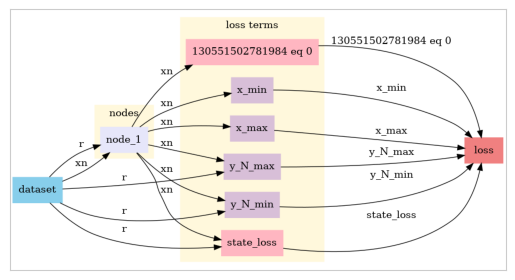

In [656]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [657]:
optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 68


In [658]:
for _ in range(5):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps += 10
    sindy_system.nsteps = nsteps
    trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 3.93449	dev_loss: 4.16915	eltime:  2.63531
epoch: 1	train_loss: 3.71981	dev_loss: 3.98022	eltime:  3.54597
epoch: 2	train_loss: 3.31891	dev_loss: 3.65230	eltime:  4.44788
epoch: 3	train_loss: 2.92232	dev_loss: 3.32683	eltime:  5.71637
epoch: 4	train_loss: 2.73671	dev_loss: 3.16444	eltime:  6.62564
epoch: 5	train_loss: 2.59483	dev_loss: 3.01231	eltime:  7.53413
epoch: 6	train_loss: 2.48413	dev_loss: 2.89527	eltime:  8.44569
epoch: 7	train_loss: 2.40317	dev_loss: 2.81329	eltime:  9.49291
epoch: 8	train_loss: 2.33961	dev_loss: 2.75180	eltime:  10.48809
epoch: 9	train_loss: 2.28834	dev_loss: 2.70108	eltime:  11.44301
epoch: 10	train_loss: 2.24642	dev_loss: 2.65927	eltime:  12.35470
epoch: 11	train_loss: 2.21120	dev_loss: 2.62398	eltime:  13.25577
epoch: 12	train_loss: 2.18105	dev_loss: 2.59457	eltime:  14.16304
epoch: 13	train_loss: 2.15498	dev_loss: 2.56962	eltime:  15.07123
epoch: 14	train_loss: 2.13224	dev_loss

In [399]:
# policy_sindy.load_state_dict(torch.load("saved_models/pt_policy_SINDY_SINDy_Model_x_0_x_1_sin(x_0)_sin(x_1)_x_0 * x_1_r_0_r_1_r_0^2_r_1^2_x_0 * r_0_x_0 * r_1_x_1 * r_0_x_1 * r_1_20250312_132400.pth"))

<All keys matched successfully>

In [770]:
nsteps = 750
step_length = 150
torch.manual_seed(2)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=0.8, randsteps=nsteps//step_length, rng=np.random.default_rng(seed=65))
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

In [767]:
# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
gt_integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
gt_integrator_node = Node(gt_integrator, ['xn', 'u'], ['x'], name='model')


In [768]:
import copy

gt_system_sindy_policy = copy.deepcopy(sindy_system)
gt_system_sindy_policy.nodes[2] = gt_integrator_node

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

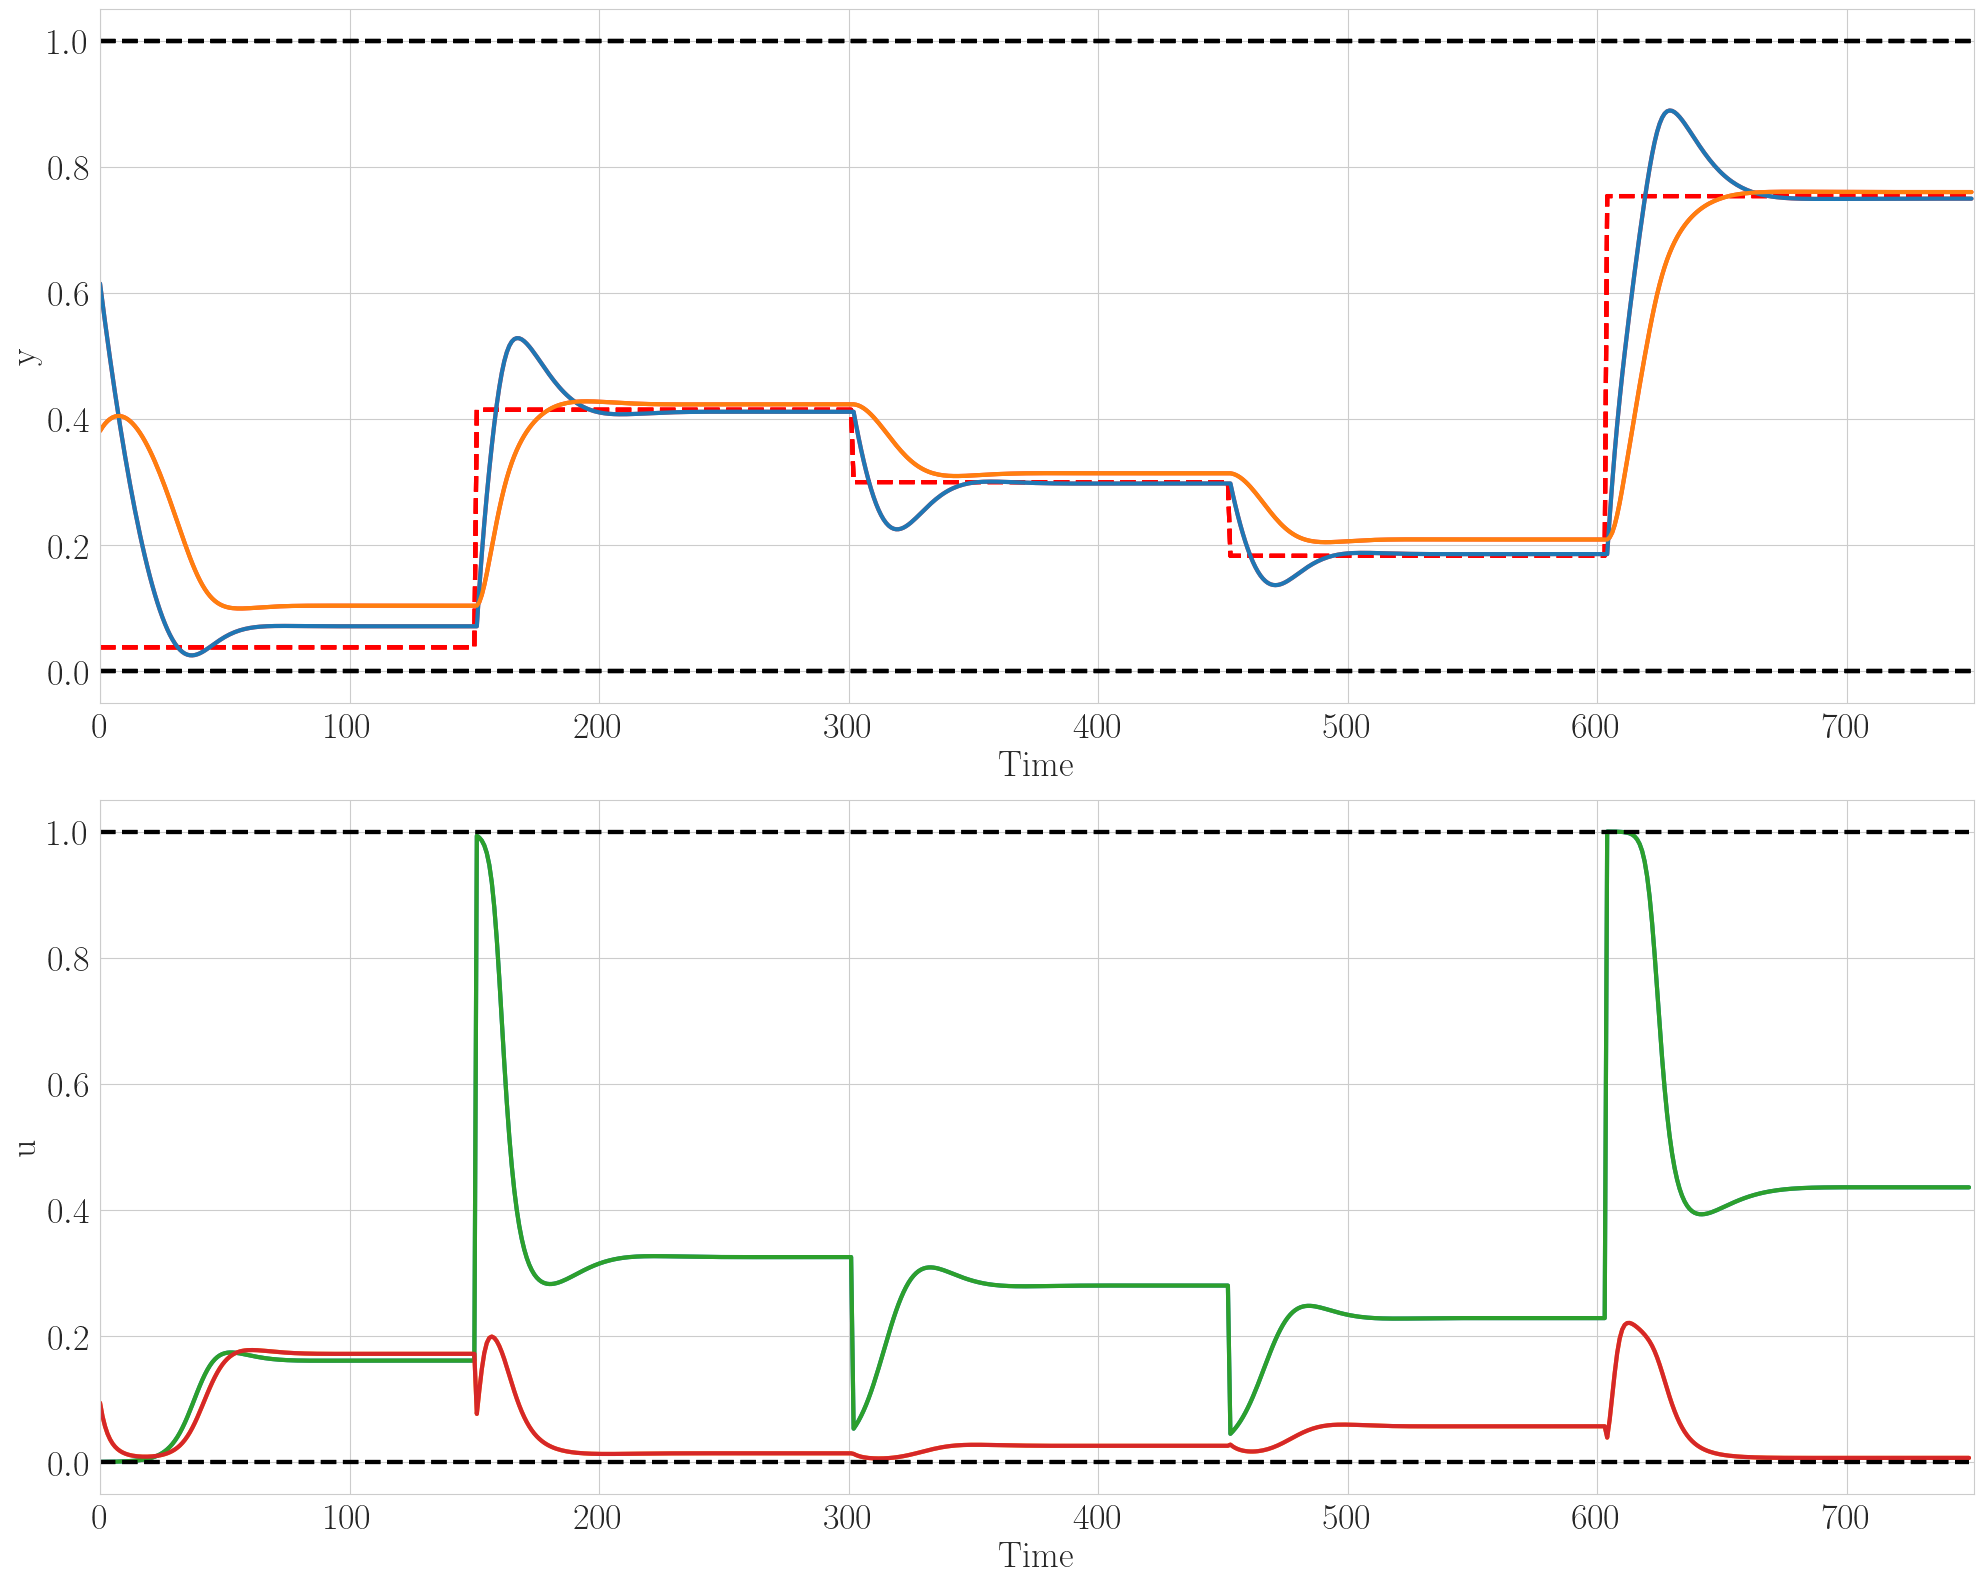

In [769]:
gt_system_sindy_policy.nsteps = nsteps
# perform closed-loop simulation
trajectories = gt_system_sindy_policy(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

In [663]:
print(policy_sindy)

dx0/dt = -3.884*x_0 + -7.186*x_1 + -5.353*sin(x_1) + -1.240*x_0 * x_1 + 11.790*r_0 + 11.802*r_1 + -2.444*sqrt(r_0) + -2.444*sqrt(r_1) + -0.911*x_0 * r_0 + -0.913*x_0 * r_1 
dx1/dt = 5.817*x_0 + -9.311*x_1 + 0.200*sin(x_0) + -5.603*sin(x_1) + -1.215*sqrt(r_0) + -1.195*sqrt(r_1) + 3.166*x_0 * r_0 + 3.166*x_0 * r_1 



In [84]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_policy_SINDY_SINDy_Model_" + "_".join(policy_sindy.library.function_names) + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(policy_sindy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy_SINDY_SINDy_Model_x_0_x_1_sin(x_0)_sin(x_1)_x_0 * x_1_r_0_r_1_r_0^2_r_1^2_x_0 * r_0_x_0 * r_1_x_1 * r_0_x_1 * r_1_20250312_132400.pth


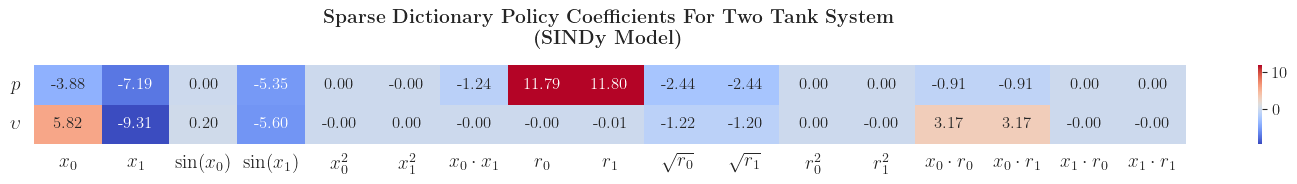

In [745]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

coefficients = policy_sindy.coef.data.numpy()

def convert_to_latex(names):
    latex_names = []
    for name in names:
        name = name.replace('*', r' \cdot ')
        name = re.sub(r'sin\((.*?)\)', r'\\sin(\1)', name)
        name = re.sub(r'sqrt\((.*?)\)', r'\\sqrt{\1}', name)
        name = re.sub(r'\^(\d+)', r'^{\1}', name)
        latex_names.append(rf"${name}$")
    return latex_names

function_names_latex = convert_to_latex(policy_sindy.library.function_names)

control_terms_latex = [r"$p$", r"$\upsilon$"]



plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(coefficients.T, annot=True, xticklabels=function_names_latex, yticklabels=control_terms_latex, cmap="coolwarm", fmt=".2f", ax=ax)

ax.set_title(r"\textbf{Sparse Dictionary Policy Coefficients For Two Tank System}" "\n" r"\textbf{(SINDy Model)}", fontsize=14, pad=15)

ax.xaxis.tick_top()  # Move x-axis ticks to the top first
ax.xaxis.set_label_position('bottom')  # Move label to the bottom
ax.tick_params(axis='x', bottom=False, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', which='major', pad=10)
plt.xticks(rotation=0, ha='center')  # Keep x-axis labels horizontal
plt.yticks(rotation=0, ha='center', fontsize=14)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar font size


plt.tight_layout()
plt.savefig(fname="results/TwoTank/TwoTank_Sparse_Policy_Coefficients_SINDy.eps", format="eps", bbox_inches="tight")
plt.show()




### Neural Policy On SINDy Dynamics

In [773]:
# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy_neural = Node(net, ['xn', 'r'], ['u'], name='neural policy')


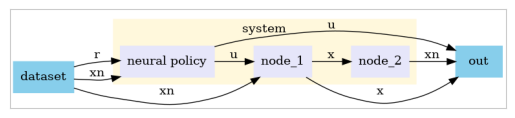

In [774]:
nsteps = 10
neural_sindy_system = System([policy_neural, integrator_node, x_bound], nsteps=nsteps)
neural_sindy_system.show()

In [775]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


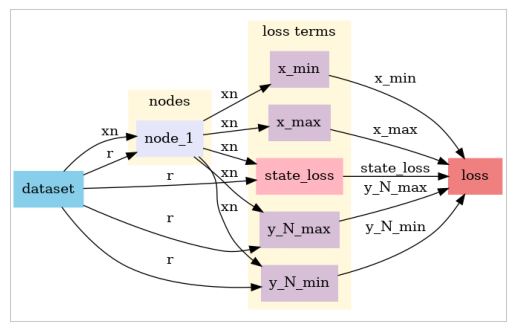

In [776]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [neural_sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [777]:
optimizer = torch.optim.AdamW(policy_neural.parameters(), lr=0.002)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 1316


In [127]:
for _ in range(5):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps += 10
    neural_sindy_system.nsteps = nsteps
    trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 3.67627	dev_loss: 3.59104	eltime:  0.86020
epoch: 1	train_loss: 3.50342	dev_loss: 3.42557	eltime:  1.24462
epoch: 2	train_loss: 3.18001	dev_loss: 3.09937	eltime:  1.56663
epoch: 3	train_loss: 2.78453	dev_loss: 2.70514	eltime:  1.88750
epoch: 4	train_loss: 2.53241	dev_loss: 2.44382	eltime:  2.20131
epoch: 5	train_loss: 2.39322	dev_loss: 2.29576	eltime:  2.52156
epoch: 6	train_loss: 2.29498	dev_loss: 2.20414	eltime:  2.83877
epoch: 7	train_loss: 2.20216	dev_loss: 2.10300	eltime:  3.15438
epoch: 8	train_loss: 2.11647	dev_loss: 2.01627	eltime:  3.47350
epoch: 9	train_loss: 2.05544	dev_loss: 1.94736	eltime:  3.79227
epoch: 10	train_loss: 2.01234	dev_loss: 1.90042	eltime:  4.10987
epoch: 11	train_loss: 1.98178	dev_loss: 1.86890	eltime:  4.43015
epoch: 12	train_loss: 1.95743	dev_loss: 1.84301	eltime:  4.74737
epoch: 13	train_loss: 1.93414	dev_loss: 1.82027	eltime:  5.06283
epoch: 14	train_loss: 1.91657	dev_loss: 1.80

In [ ]:
gt_system_neural_policy = copy.deepcopy(neural_sindy_system)
gt_system_neural_policy.nodes[1] = gt_integrator_node

In [ ]:
nsteps = 750
torch.manual_seed(2)
seed = 65
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

gt_system_neural_policy.nsteps = nsteps
# perform closed-loop simulation
trajectories = gt_system_neural_policy(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

In [133]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_policy_Neural_SINDy_Model_" + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(policy_sindy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy_Neural_SINDy_Model__20250312_145106.pth


In [711]:
import time
import pickle
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

def trajectory_dump(nsteps, step_length, cl_system, policy_name:str, dynamics_name:str):

    # generate reference
    np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=nsteps//step_length, rng=np.random.default_rng(seed=20))
    R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
    torch_ref = torch.cat([R, R], dim=-1)
    torch.manual_seed(0)
    # generate initial data for closed loop simulation
    data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
            'r': torch_ref}

    cl_system.nsteps = nsteps

    print(data['r'].shape)

    times = []
    trajectories = None

    for i in range(50):
        start = time.time()
        # perform closed-loop simulation
        trajectories = cl_system(data)
        end = time.time() - start
        times.append(end)

    traj = dict()
    traj['traj'] = trajectories
    traj['times'] = times
    filename = policy_name + "_" + dynamics_name + ".pkl"
    save_path = os.path.join(save_dir, filename)

    with open(save_path, "wb") as f:
        pickle.dump(traj, f)


In [ ]:
trajectory_dump(nsteps=500, step_length=100, cl_system=gt_system_neural_policy, policy_name="policy_NN", dynamics_name="dynamics_SINDy")

In [162]:
policy_name = "policy_NN"
dynamics_name = "dynamics_SINDy"
filename = policy_name + "_" + dynamics_name + ".pkl"
save_dir = "results"
save_path = os.path.join(save_dir, filename)


In [163]:
with open(save_path, "rb") as f:
    loaded_data = pickle.load(f)


In [713]:
trajectory_dump(nsteps=500, step_length=100, cl_system=gt_system_sindy_policy, policy_name="policy_Sparse", dynamics_name="dynamics_SINDy")

torch.Size([1, 501, 2])


### Online Adaptation
#### Sparse Dictionary Policy

##### Changing ODE params

In [611]:
two_tank.c1 = nn.Parameter(torch.tensor(0.15), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(0.03), requires_grad=False)
print("New c1: ",two_tank.c1)
print("New c2: ",two_tank.c2)

New c1:  Parameter containing:
tensor(0.1500)
New c2:  Parameter containing:
tensor(0.0300)


(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

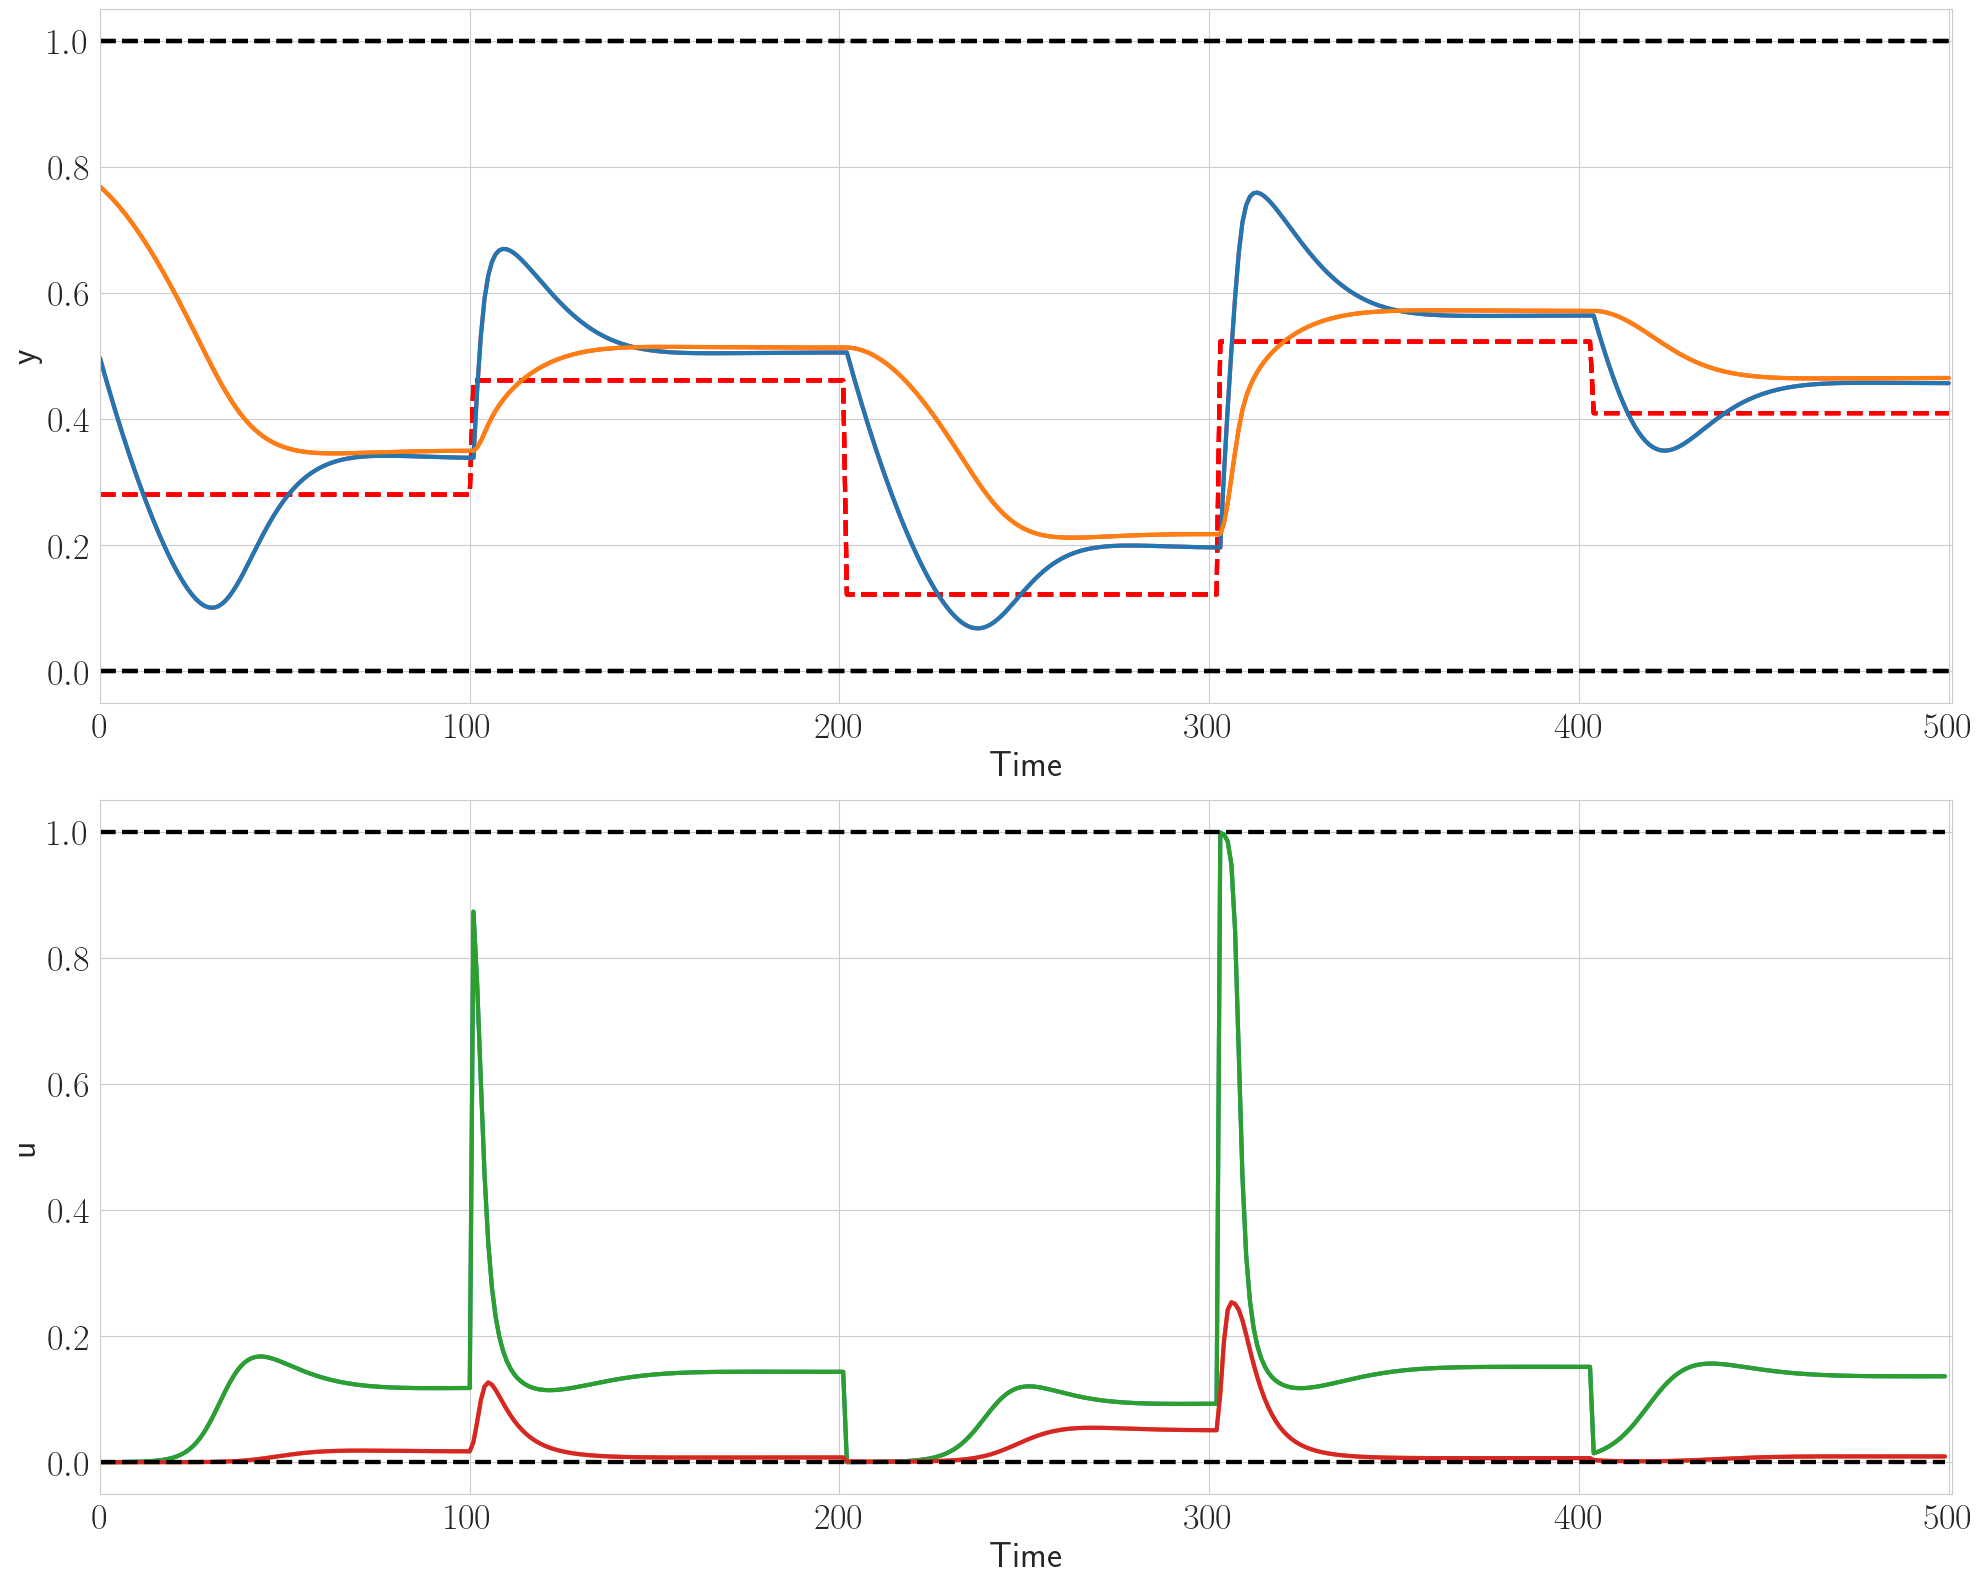

In [612]:
gt_system_sindy_policy.nsteps = nsteps
# perform closed-loop simulation
trajectories_before_adaptation = gt_system_sindy_policy(data)

# plot closed loop trajectories
pltCL(Y=trajectories_before_adaptation['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories_before_adaptation['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories_before_adaptation['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

In [614]:
#setting intial value and the horizon
horizon = 50
#defining criterion and optimizer
criterion = torch.nn.MSELoss()
steps_trajectories = {}


In [615]:
for steps in [10,30,50]:
    new_cl_system = copy.deepcopy(gt_system_sindy_policy)
    policy = new_cl_system.nodes[0]
    x_trajectory = data['xn'].detach()[:, 0, :].unsqueeze(1)
    optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)
    #Online adaptation loop:
    for i in range (1,len(data['r'][0])):
        print('------', "Steping time step: ",i, '-------')
        #We rollout the closed loop system with the initial value:
        new_cl_system.nsteps = i
        trajectories = new_cl_system(data)

        #gradually increasing the horizon:
        l_horizon = min(i,horizon)

        #Getting the last l_horizon data from test data and calculate the loss
        T_xn = len(trajectories['xn'][0])
        loss = 5. * criterion(trajectories['xn'][:,-l_horizon:, :], trajectories['r'][:, T_xn - l_horizon : T_xn, :]) + criterion(trajectories['xn'], trajectories['r'][:, :T_xn])

        #backprop through policy network
        optimizer.zero_grad()
        loss.backward()

        #taking gradient update steps
        for _ in range(steps):
            optimizer.step()
        print('-------', f"Loss in {i}th steps: ",loss.item(), '-------')

        #setting the initial value to the latest timestep (this is for knowing how the controller is performing online):
        new_cl_system.nsteps = 1
        next_step_data = new_cl_system({'xn': x_trajectory[:,-1,:].unsqueeze(0), 'r': data['r'][:, len(x_trajectory[0]), :].unsqueeze(0)})
        x_trajectory = torch.cat([x_trajectory, next_step_data['xn'].detach()[:,-1:,:]], dim=1)

    steps_trajectories[steps] = {}
    steps_trajectories[steps]["xn"] = x_trajectory
    steps_trajectories[steps]["u"] = trajectories['u'].detach()





------ Steping time step:  1 -------
------- Loss in 1th steps:  0.8171548843383789 -------
------ Steping time step:  2 -------
------- Loss in 2th steps:  0.7975398302078247 -------
------ Steping time step:  3 -------
------- Loss in 3th steps:  0.7786384224891663 -------
------ Steping time step:  4 -------
------- Loss in 4th steps:  0.7604238986968994 -------
------ Steping time step:  5 -------
------- Loss in 5th steps:  0.7428704500198364 -------
------ Steping time step:  6 -------
------- Loss in 6th steps:  0.7259535193443298 -------
------ Steping time step:  7 -------
------- Loss in 7th steps:  0.7096492052078247 -------
------ Steping time step:  8 -------
------- Loss in 8th steps:  0.6939343214035034 -------
------ Steping time step:  9 -------
------- Loss in 9th steps:  0.6787864565849304 -------
------ Steping time step:  10 -------
------- Loss in 10th steps:  0.6641849875450134 -------
------ Steping time step:  11 -------
------- Loss in 11th steps:  0.650108695

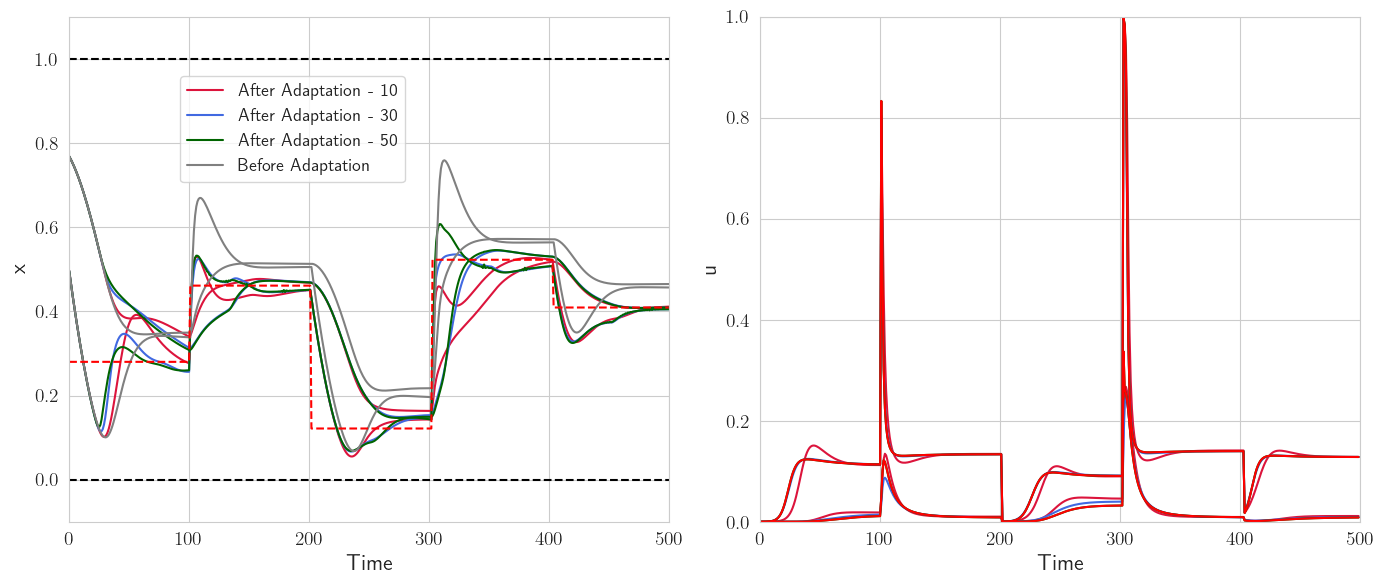

In [735]:
import random
nsteps = len(x_trajectory[0])-1

sns.set_style('whitegrid')
# Generate sample data (Replace these with your actual data)
time = np.arange(nsteps+1)  # Time steps

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two subplots side by side
colors = {10:'#DC143C', 30: "#4169E1", 50: "#006400"}
# Plot x vs Time
for steps in steps_trajectories:
    results = steps_trajectories[steps]
    color = (random.random(), random.random(), random.random())
    axes[0].plot(time, results['xn'].detach().reshape(nsteps + 1, 2).numpy()[:,0], color=colors[steps], label=f'After Adaptation - {steps}')
    axes[0].plot(time, results['xn'].detach().reshape(nsteps + 1, 2).numpy()[:,1], color=colors[steps])
    axes[1].plot(time[:-1], results['u'].detach().reshape(nsteps, 2).numpy()[:,0], color=colors[steps], label='After Adaptation')
    axes[1].plot(time[:-1], results['u'].detach().reshape(nsteps, 2).numpy()[:,1], color=colors[steps])
axes[0].plot(time, trajectories_before_adaptation['xn'].detach()[:,:nsteps+1,:].reshape(nsteps + 1, 2).numpy()[:,0], color='grey', label='Before Adaptation')
axes[0].plot(time, trajectories_before_adaptation['xn'].detach()[:,:nsteps+1,:].reshape(nsteps + 1, 2).numpy()[:,1], color='grey')

axes[0].set_xlabel("Time")
axes[0].set_ylabel("x")
axes[0].set_xlim([0, nsteps])
axes[0].set_ylim([-0.1, 1.1])
axes[0].hlines([0, 1], xmin=0, xmax=500.0, colors='black', linestyles='dashed')  # Reference lines
axes[0].plot(time, data['r'].detach()[:,:nsteps+1,:].reshape(nsteps + 1, 2).numpy()[:,0], 'r--')  # Red dashed line for reference

# Generate sample data (Replace these with your actual data)
time = np.arange(nsteps)
# Plot u vs Time
axes[1].plot(time, results['u'].detach().reshape(nsteps, 2).numpy()[:,0], color='red', label='Before Adaptation')
axes[1].plot(time, results['u'].detach().reshape(nsteps, 2).numpy()[:,1], color='red', label='Before Adaptation')

axes[1].set_xlabel("Time")
axes[1].set_ylabel("u")
axes[1].set_xlim([0, nsteps])
axes[1].set_ylim([0, 1])

# Add legend
axes[0].legend(loc='upper left', bbox_to_anchor=(0.17, 0.90), fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()


## Additive Noise

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

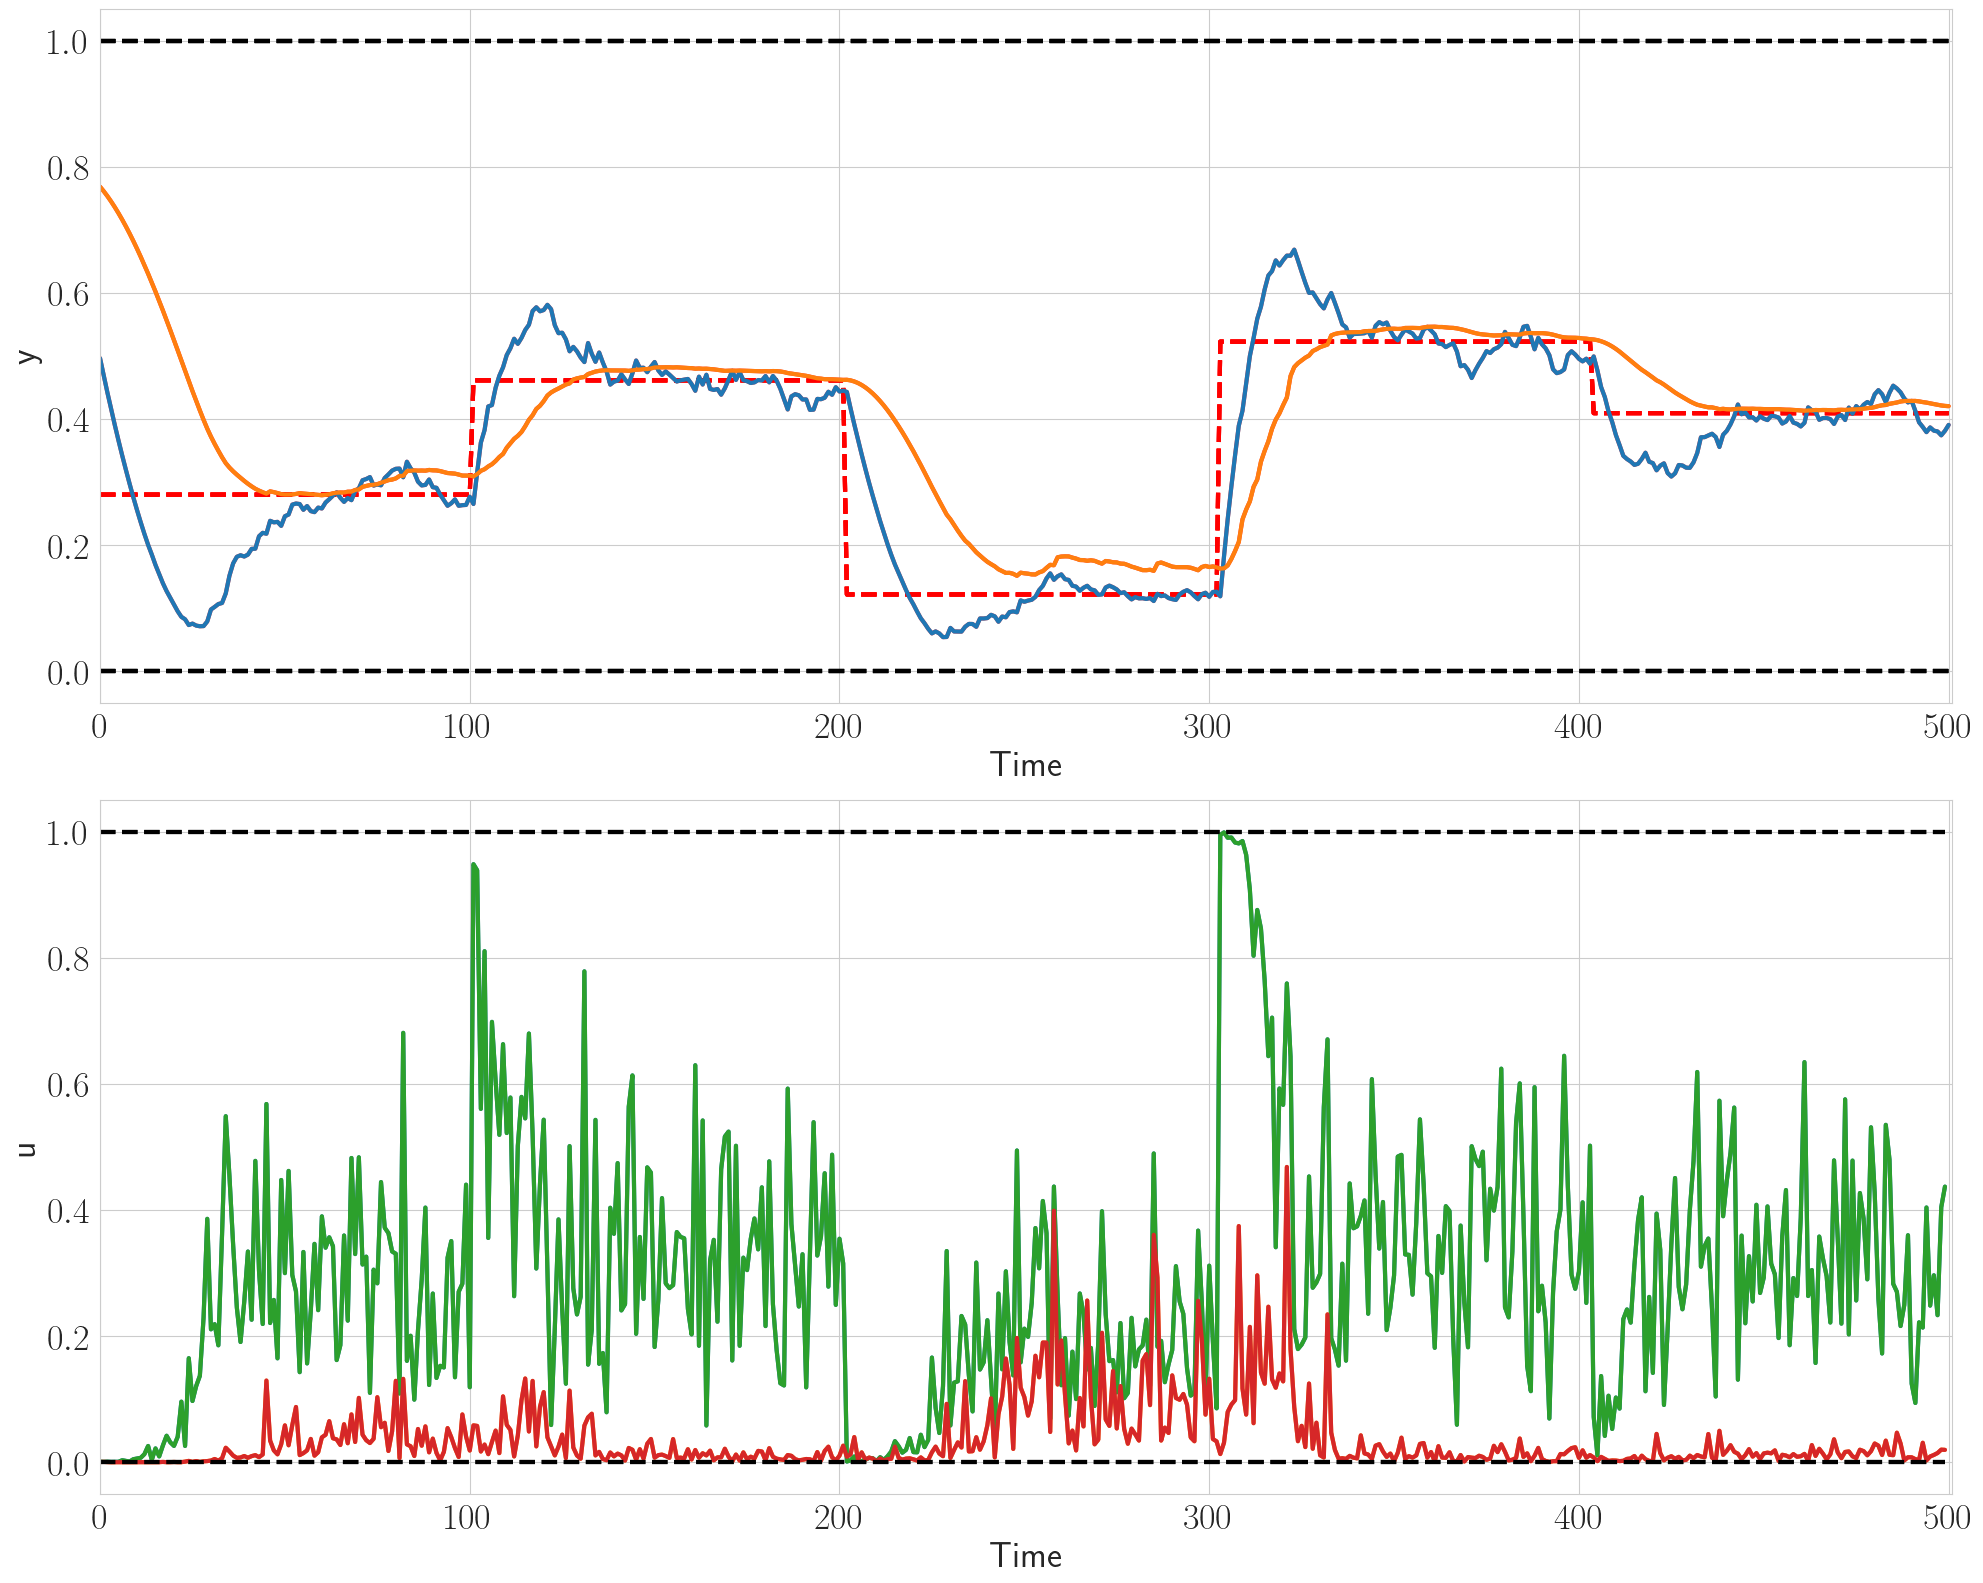

In [736]:
noisy_cl_system = copy.deepcopy(gt_system_sindy_policy)
noises = [5e-2]
for noise_level in noises:
    noise = Node(lambda x: torch.randn(x.shape)*noise_level + x, ['xn'], ['xnoise'])
    policy_node = Node(noisy_cl_system.nodes[0].callable, ['xnoise', 'r'], ['u_unbound'])
    noisy_cl_system = System([noise, policy_node, noisy_cl_system.nodes[1], noisy_cl_system.nodes[2], noisy_cl_system.nodes[3]], nsteps=nsteps)


noisy_cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = noisy_cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

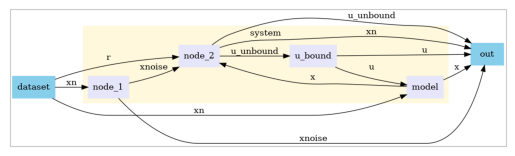

In [737]:
noisy_cl_system.show()

In [740]:
#setting intial value and the horizon
horizon = 50
#defining criterion and optimizer
criterion = torch.nn.MSELoss()
noises_trajectories = {}
noises = [1e-3, 1e-2, 1e-1, 1]

In [741]:
for noise_level in noises:
    noisy_cl_system = copy.deepcopy(gt_system_sindy_policy)
    noise = Node(lambda x: torch.randn(x.shape)*noise_level + x, ['xn'], ['xnoise'])
    policy_node = Node(noisy_cl_system.nodes[0].callable, ['xnoise', 'r'], ['u_unbound'])
    noisy_cl_system = System([noise, policy_node, noisy_cl_system.nodes[1], noisy_cl_system.nodes[2], noisy_cl_system.nodes[3]])
    x_trajectory = data['xn'].detach()[:, 0, :].unsqueeze(1)
    optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.001)

    #Online adaptation loop:
    for i in range (1,len(data['r'][0])):
        print('------', "Steping time step: ",i, '-------')
        #We rollout the closed loop system with the initial value:
        noisy_cl_system.nsteps = i
        trajectories = noisy_cl_system(data)

        #gradually increasing the horizon:
        l_horizon = min(i,horizon)

        #Getting the last l_horizon data from test data and calculate the loss
        T_xn = len(trajectories['xn'][0])
        loss = 5. * criterion(trajectories['xn'][:,-l_horizon:, :], trajectories['r'][:, T_xn - l_horizon : T_xn, :]) + criterion(trajectories['xn'], trajectories['r'][:, :T_xn])

        #backprop through policy network
        optimizer.zero_grad()
        loss.backward()

        #taking gradient update steps
        for _ in range(5):
            optimizer.step()
        print('-------', f"Loss in {i}th steps: ",loss.item(), '-------')

        #setting the initial value to the latest timestep (this is for knowing how the controller is performing online):
        noisy_cl_system.nsteps = 1
        next_step_data = noisy_cl_system({'xn': x_trajectory[:,-1,:].unsqueeze(0), 'r': data['r'][:, len(x_trajectory[0]), :].unsqueeze(0)})
        x_trajectory = torch.cat([x_trajectory, next_step_data['xn'].detach()[:,-1:,:]], dim=1)

    noises_trajectories[noise_level] = {}
    noises_trajectories[noise_level]["xn"] = x_trajectory
    noises_trajectories[noise_level]["u"] = trajectories['u'].detach()

------ Steping time step:  1 -------
------- Loss in 1th steps:  0.8049991130828857 -------
------ Steping time step:  2 -------
------- Loss in 2th steps:  0.7795475125312805 -------
------ Steping time step:  3 -------
------- Loss in 3th steps:  0.7553231716156006 -------
------ Steping time step:  4 -------
------- Loss in 4th steps:  0.7322627305984497 -------
------ Steping time step:  5 -------
------- Loss in 5th steps:  0.7103110551834106 -------
------ Steping time step:  6 -------
------- Loss in 6th steps:  0.6894116401672363 -------
------ Steping time step:  7 -------
------- Loss in 7th steps:  0.6695120930671692 -------
------ Steping time step:  8 -------
------- Loss in 8th steps:  0.6505613923072815 -------
------ Steping time step:  9 -------
------- Loss in 9th steps:  0.6325098276138306 -------
------ Steping time step:  10 -------
------- Loss in 10th steps:  0.6153157949447632 -------
------ Steping time step:  11 -------
------- Loss in 11th steps:  0.598933041

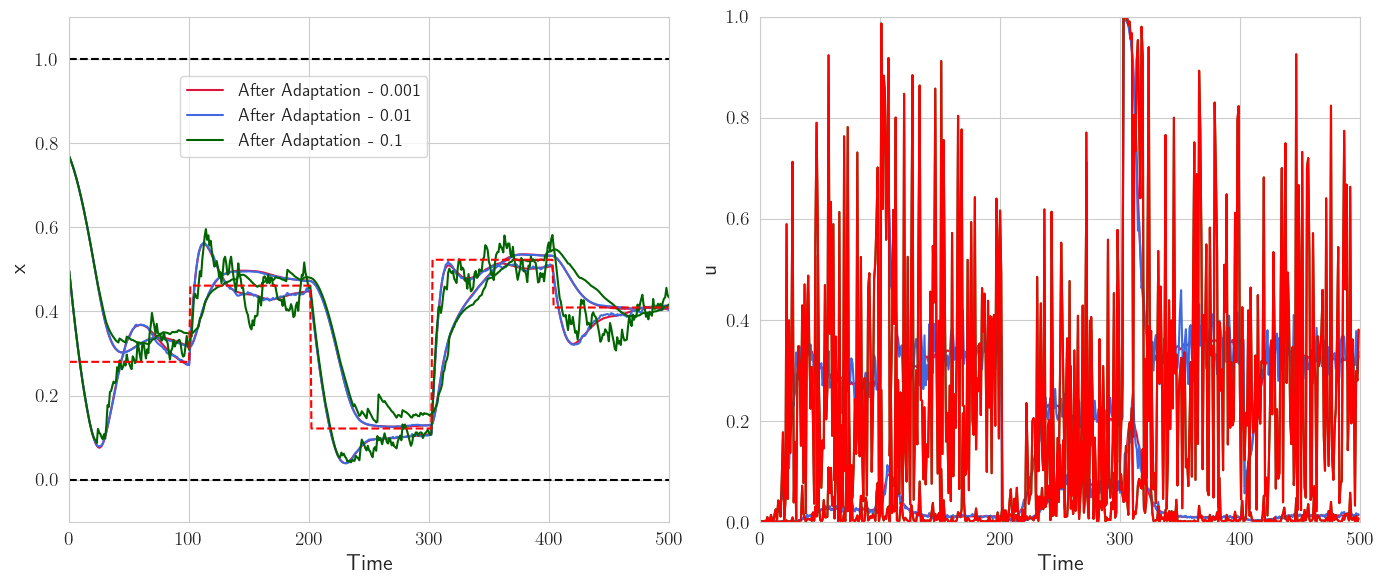

In [744]:
import random
nsteps = len(x_trajectory[0])-1

sns.set_style('whitegrid')
# Generate sample data (Replace these with your actual data)
time = np.arange(nsteps+1)  # Time steps

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two subplots side by side
colors = {1e-3:'#DC143C', 1e-2: "#4169E1", 1e-1: "#006400"}
# Plot x vs Time
for steps in noises_trajectories:
    if steps == 1:
        continue
    results = noises_trajectories[steps]
    color = (random.random(), random.random(), random.random())
    axes[0].plot(time, results['xn'].detach().reshape(nsteps + 1, 2).numpy()[:,0], color=colors[steps], label=f'After Adaptation - {steps}')
    axes[0].plot(time, results['xn'].detach().reshape(nsteps + 1, 2).numpy()[:,1], color=colors[steps])
    axes[1].plot(time[:-1], results['u'].detach().reshape(nsteps, 2).numpy()[:,0], color=colors[steps], label='After Adaptation')
    axes[1].plot(time[:-1], results['u'].detach().reshape(nsteps, 2).numpy()[:,1], color=colors[steps])
# axes[0].plot(time, trajectories_before_adaptation['xn'].detach()[:,:nsteps+1,:].reshape(nsteps + 1, 2).numpy()[:,0], color='grey', label='Before Adaptation')
# axes[0].plot(time, trajectories_before_adaptation['xn'].detach()[:,:nsteps+1,:].reshape(nsteps + 1, 2).numpy()[:,1], color='grey')

axes[0].set_xlabel("Time")
axes[0].set_ylabel("x")
axes[0].set_xlim([0, nsteps])
axes[0].set_ylim([-0.1, 1.1])
axes[0].hlines([0, 1], xmin=0, xmax=500.0, colors='black', linestyles='dashed')  # Reference lines
axes[0].plot(time, data['r'].detach()[:,:nsteps+1,:].reshape(nsteps + 1, 2).numpy()[:,0], 'r--')  # Red dashed line for reference

# Generate sample data (Replace these with your actual data)
time = np.arange(nsteps)
# Plot u vs Time
axes[1].plot(time, results['u'].detach().reshape(nsteps, 2).numpy()[:,0], color='red', label='Before Adaptation')
axes[1].plot(time, results['u'].detach().reshape(nsteps, 2).numpy()[:,1], color='red', label='Before Adaptation')

axes[1].set_xlabel("Time")
axes[1].set_ylabel("u")
axes[1].set_xlim([0, nsteps])
axes[1].set_ylim([0, 1])

# Add legend
axes[0].legend(loc='upper left', bbox_to_anchor=(0.17, 0.90), fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()
